In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [17]:
# Load the baseline stoichiometric matrix and molecular properties
Sdf = pd.read_csv('base_stoich_matrix.csv', index_col=0)
mol_props_df = pd.read_csv('base_molecular_props.csv', index_col=0)

# Each molecule has a number of carbon atom, a nominal oxidation state (NOSC)
# and is either internal or not. Flux must be balanced at steady state for 
# internal molecules, but concentrations of external molecules can change with time.
mol_props_df

# Some notes on "protein" carbon in this model...
#
# For now, protein is considered external since the first-pass model does not account 
# for growth dependent dilution. It seems that this can be handled in a linear framework
# by solvin an LP at each growth rate and choosing the maximum rate at which the allocation
# is feasible, as in Goezler et al. 2015. 
#
# Moreover, while a typical amino acid (averaged over the proteome) has ≈5 C atoms and NOSC
# from -0.1 to -0.3, I assumed 3 C and NOSC -0.333 (dNOSC = -1.0 from pyruvate) to keep the
# numbers round and the math simple for now.  

,NC,NOSC,internal,note
nutrient,6,0.000000,0,"""glucose"""
intermediate,3,0.666667,1,"""pyruvate"""
precursor,3,-0.333333,1,"default NOSC values, for now assuming 3 C/AA f..."
fermentation_product,3,0.000000,0,"""lactate"""
respiration_product,1,4.000000,0,"""CO2"""
EC,1,0.000000,1,Oxidized single e- carrier with 1 carbon to en...
ECH,1,-1.000000,1,Reduced 1e- carrier.
ADP,10,0.000000,1,NaN
ATP,10,0.000000,1,NaN
protein,3,-0.333333,0,"default NOSC values, for now assuming 3 C/AA f..."


In [18]:
# Annotated stoichiometric matrix is a dataframe: make it a numpy array/matrix. 
numeric_cols = Sdf.columns[0:-1]
S = Sdf[numeric_cols].values.copy()

# Peek at the annotated one
Sdf

# Some notes on the translation process in the model (see above notes on "proteins").
# Here I've written translation as converting 1 precursor (3 C atoms) into one "protein"
# (also 3 C atoms). This is because my current rate constant estimates are based on
# generic kcats of 1-10 /s which is about right for a single polymerization reaction
# but not for the production of a whole protein.
# 
# I need to think a little more about the right way to model translation, i.e. whether it
# should be carbon-centric or protein centric (modeling the production of whole proteins).
# 
# On "homeostasis". This is a bad name. Basically we need an ATP sink so that it is always
# possible to balance ATP production and consumption. I chose to assume that this ATP
# consumption rate scales with the "other" fraction of the proteome so that the model has a 
# free variable that can be used to ensure ATP/ADP steady-state. 

,nutrient,intermediate,precursor,fermentation_product,respiration_product,EC,ECH,ADP,ATP,protein,note
process,,,,,,,,,,,
glycolysis,-1,2,0,0,0,-4,4,-2,2,0,"EMP glycolysis : 2 ATP, 2 pyr/glucose, 4 e -"
fermentation,0,-1,0,1,0,2,-2,0,0,0,"pyruvate to lactate fermentation, no ATP"
TCA_cycle,0,-1,0,0,3,-10,10,-1,1,0,"TCA cycle, 3 CO2/pyr, 1 GTP, 10 e-"
respiration,0,0,0,0,0,1,-1,-1,1,0,"O2 respiration, 1 ATP per e-"
anabolism,0,-1,1,0,0,3,-3,2,-2,0,biosynthesis of an average amino acid
translation,0,0,-1,0,0,0,0,4,-4,1,"translation, 4 ATP/aa"
homeostasis,0,0,0,0,0,0,0,1,-1,0,NaN


In [4]:
# Check carbon conservation of the reactions in the stoichiometric matrix. 
S @ mol_props_df.NC

array([0, 0, 0, 0, 0, 0, 0])

In [20]:
# Check e- conservation; total e- per molecule = NOSC*NC
electrons_per_molecule = mol_props_df.NC*mol_props_df.NOSC
e_balance = S @ electrons_per_molecule
# Display rounded electron balance - not exactly balanced due to numerics. 
display(np.round(e_balance))

# Note that respiration is not e- balanced here (4th entry)
# because we do not explicitly model the terminal e- acceptor.
# i.e. there is no O2 in the model.

array([ 0., -0., -0.,  1.,  0.,  0.,  0.])

In [22]:
# 6 named process in the matrix, plus "other"
n_processes = 7 
n_concs = 10

# per-process fluxes j_i, units of mol/L cell volume/hour
# j_i = v_i * phi_i * rho_prot
phis = cp.Variable(name='phis', shape=n_processes, nonneg=True)

# number of enzymes: same order as Sdf rows. 
n_enz = [
    10,  # glycolysis
    1,   # lactate fermentation
    8,   # TCA cycle
    30,  # repiratory chain ≈1000 kDa
    5,   # typical amino acid biosynthesis is a few steps
    25,  # bacterial ribosome 2.3 MDa, 35% of which is protein,
    1,   # assume in "homeostasis" ATP is coupled to single active sites. 
]

# v_i: rate constant [mol/s/g] per protein
# default value set by assuming kcat ≈ 10 /s, MW = 30 kDa = 3e4 g/mol.
# v_i = 10/3e4 = 3.33e-4 mol/g/s.
default_v = 3e-4
# default vi are rescaled by the number of proteins involved so that
# costs (1/vi) reflect the mass of protein needed to catalyze 1 flux unit
default_vs = np.ones(n_processes)*default_v/n_enz
vs = cp.Parameter(name='vs', shape=n_processes, 
                  value=default_vs, pos=True)

# rho_prot = M_prot/V_cell protein mass density ≈ 250 g/L (Milo 2013)
rho_prot = cp.Parameter(name='rho_prot', value=250, pos=True)

# fluxes j_i = rho_prot*v_i*phi_i
# phi_i: proteome fraction [unitless]
js = rho_prot*cp.multiply(vs, phis)

# sum(phi_i) = 1 by defn
allocation_constr = cp.sum(phis) == 1

# maximize growth rate by maximization of translation flux
# translation is the second-to-last process
obj = cp.Maximize(js[-2])

# Can only enforce balancing for internal metabolites, 
# but this means ATP, e- and C will be balanced internally
internal_mets = mol_props_df.internal.values.copy()
flux_balance = S.T @ js
internal_flux_balance = cp.multiply(flux_balance, internal_mets)
cons = [internal_flux_balance  == 0, allocation_constr]
prob = cp.Problem(obj, cons)

# Solve the problem in verbose mode to see that its feasible
max_obj = prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Oct 27 10:36:04 AM: Your problem has 7 variables, 2 constraints, and 8 parameters.
(CVXPY) Oct 27 10:36:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 27 10:36:04 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 27 10:36:04 AM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 27 10:36:04 AM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Oct 27 10:36:04 AM: Applying reduction EvalParams
(CVXPY) Oct 27 10:36:04 AM: Applying r

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [24]:
max_phi_rs = np.arange(0.0, 0.2, 0.01)
soln_phis = []
soln_js = []
for max_phi_r in max_phi_rs:
    cons = [internal_flux_balance  == 0, allocation_constr, phis[-2] <= max_phi_r]
    prob = cp.Problem(obj, cons)
    soln = prob.solve()
    soln_phis.append(phis.value.copy())
    soln_js.append(js.value.copy())
    
opt_phis = pd.DataFrame(np.vstack(soln_phis), columns=Sdf.index)
opt_js = pd.DataFrame(np.vstack(soln_js), columns=Sdf.index)

Index(['glycolysis', 'fermentation', 'TCA_cycle', 'respiration', 'anabolism',
       'translation', 'homeostasis'],
      dtype='object', name='process')

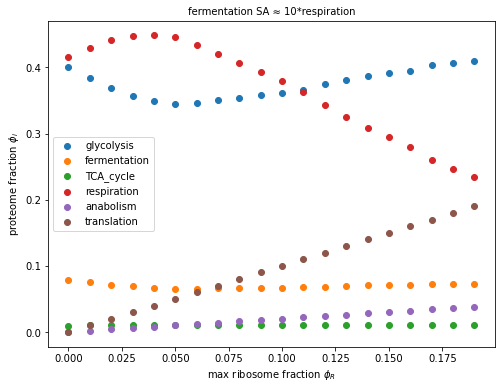

In [27]:
plt.figure(figsize=(8,6))
for c in opt_phis.columns:
    if c == 'homeostasis':
        continue
    plt.scatter(max_phi_rs, opt_phis[c], label=c)
    
plt.legend(loc='best', framealpha=0.8)
plt.xlabel('max ribosome fraction $\phi_R$', fontsize=10)
plt.ylabel('proteome fraction $\phi_i$', fontsize=10)
plt.savefig('../output/linear_model_overflow.png', facecolor='w', dpi=600)
plt.show()

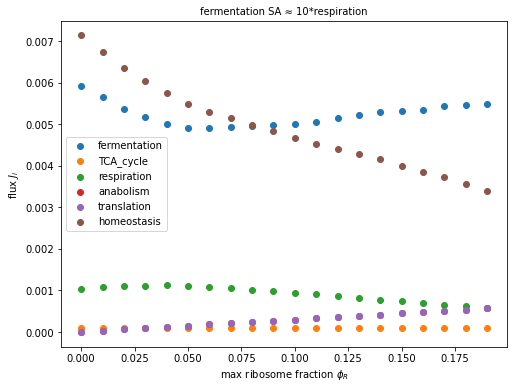

In [28]:
plt.figure(figsize=(8,6))
for c in opt_js.columns[1:]:
    plt.scatter(max_phi_rs, opt_js[c], label=c)
    
plt.legend(loc='best', framealpha=0.8)
plt.xlabel('max ribosome fraction $\phi_R$', fontsize=10)
plt.ylabel('flux $J_i$', fontsize=10)
plt.savefig('../output/linear_model_overflow.png', facecolor='w', dpi=600)
plt.show()